# BERT Narration Classification

### Final Project - Vincent Gu
### DATASCI 266 - Section 3 - Summer 2023

## Background

As a model framework, BERT's pre-training on existing 'real' data such as Wikipedia provides an enormous repository
of context and position based word embeddings suitable as a starting point for a myriad of language tasks. Tuning this 
pre-trained model can lead to increased task accuracy for specific tasks and datasets.

However, how does BERT perform when presented with fictional text that differs substantially from the non-fiction
(Wikipedia) data it was trained on? Furthermore, how well can BERT be fine-tuned with fictional text to increase 
performance at a classification text? Finally, how well can BERT pick up subtle variations in word meanings based on 
surrounding fictional context?

To begin answering these questions, I leveraged the base BERT model with the science fiction novel 'Dark Age' by 
Pierce Brown. In the novel Brown crafts a dystopia in which mankind is genetically engineered into twelve distinct castes (denoted as colors in the book). Each color holds a certain function in society and inter-color marriage is forbidden. For example, Gold as the ruling class are genetically engineered to be taller, stronger and smarter than Reds who toil as menial slave laborers.

The novel contains narration from 5 different individuals of different colors and perspectives and the corresponding language task involves classifying an excerpt of the text based on which narrator the model believes the text came 
from. I then looked to improve model performance by fine-tuning. Finally, I analyzed various out-of-context words 
specific to the world Pierce Brown created to determine if the fine-tuned BERT could pick up nuanced word meanings,
as represented by word embeddings, based on narrator.

The five narrators (classification buckets) are:
1. Darrow: A Red genetically 'carved' into a Gold. A revolutionary warlord
2. Virginia: The Gold Sovereign (ruler) of a more egalitarian/reformed society
3. Ephraim: A Gray (foot soldier)
4. Lyria: A Red disillusioned with Virginia's society
5. Lysander: A Gold, the last grandchild of the former Sovereign, a fascist slaver

## Objectives

- Build and train a fine-tuned BERT model to classify excerpts from the novel based on its narrator
- Determine if the model can pick up nuanced out-of-context word meanings based on the perspectives of each narrator

## Project Directory

* data (directory)
  * dark-age-raw-text.txt
* helpermodule (directory)
  * data.py
* models (directory - not in Github due to model size - https://drive.google.com/drive/u/1/folders/17EIarAjczgkHQAX7CjGFsUeq71Tdbk_T)
* screenshots (directory)
* **main.ipynb**
* BERT_base.py
* train_BERT_base.sh

## Data Setup

In [15]:
import sys
sys.path.append('helpermodule')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from IPython.display import Image, display

import numpy as np
from numpy import dot
from numpy.linalg import norm

from helpermodule import data
from data import get_chapter_data, get_excerpt_data, format_data
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

The custom helpermodule package processes the raw text into labeled data. We have 2,214 excerpts of 128 words. Here is an example of the label associated with a given excerpt. 

In [2]:
excerpt_labels, excerpt_examples = get_excerpt_data(n_words=128)
print("# Excerpts:", len(excerpt_labels))
print(excerpt_labels[2000])
print(excerpt_examples[2000])

# Excerpts: 2214
Darrow
wheel away back into my world. The Reds who came to my aid stand watching me. There are six of the sunbaked laborers. Not a one older than twenty. They stand with their ﬁsts in a salute. I open an external pouch manually and ﬁnd the helm key. I insert it into the collar until a latch pops. I roll back the wolf’s head helm and suck down the fresh air. The young Reds stare up at me. They might have thought they recognized my armor before, but now they see my face, and they take a step back in fear. “I lost my razor on the rooftops. Find it.” By the time the skinniest of them returns with my slingBlade in his trembling hands, another crowd has


How balanced are our classes?

For the most part, relatively balanced. But the 'Ephraim' and 'Virginia' narrations aren't quite as prevalent as 'Lysander'.

In [3]:
np.unique(excerpt_labels, return_counts=True)

(array(['Darrow', 'Ephraim', 'Lyria', 'Lysander', 'Virginia'], dtype='<U8'),
 array([456, 458, 367, 556, 377]))

# BERT Setup

In [39]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from keras.utils import to_categorical
import seaborn as sns

import matplotlib.pyplot as plt
from transformers import BertTokenizer, TFBertModel
from transformers import logging
tf.get_logger().setLevel('ERROR')

In [5]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_model = TFBertModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


## Training the Fine-Tuned Models

To gauge various model training behaviors, the fine-tuned BERT model was trained using a number of batch sizes: **4, 8, 16** and two excerpt sizes: **64, 128**. The range of batch size is limited due to memory constraints - increasing batch size beyond 16 killed the kernel. I also considered the number of TFBertModel layers to retrain each epoch and trained models with: **0, 6, 12** retrainable layers. In this setting, a single labeled observation (data point) would be comprised of either 100 or 256 words. Training details are saved as screenshots under the **training_screenshots** folder.

For example, the best performing model **bert_classification_model_16_128_12.h5** has a batch size of 18, a excerpt length of 128, and 12 (all) BERT layers retrained.

As BERT's underlying transformer architecture requires significant computational resources, models were trained using GPU as opposed to CPU. Attempting to train on CPU look approximately two hours per epoch which was cut to between 2-15 minutes per epoch with GPU. Due to the size of these models, they were trained via commandline with the shell script **train_BERT.sh** which makes sucessive calls to **BERT_base.py**. These individual .py calls are parameterized with both the batch size, excerpt size and number of retrainable layers.

Note that the large variance in training time is almost entirely due to batch size and number of retrained BERT layers. The model with the shortest training time had a large batch of 16 and 0 retrained layers. On the flip side the model with the longest training time had a small batch of 4 and 12 retrained layers.

The three BERT inputs of input ids, token type ids and attention mask are consolidated into the [CLS] token embedding which is then fed into successive fully connected dense layers and a final five-class softmax classification output layer.

## Model Performance

Following obvious intuition, we can clearly see how important retraining BERT layers is for fine-tuning for the classification language task. The following screenshot details validation accuracy over 10 training epochs for a model with no BERT layer retraining. We see training and validation accuracy increase very slightly over each epoch but not nearly to the extent we would want. Without retraining BERT layers the only parameters updated in back-propagation are those in the fully connected dense layers which is clearly insufficient.

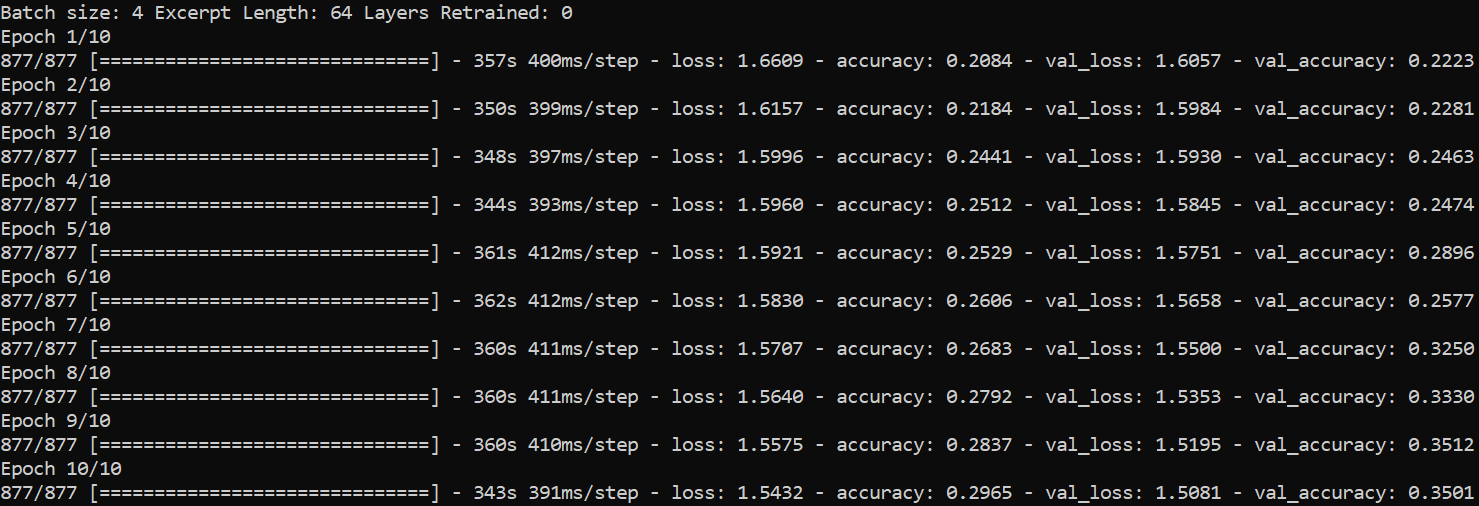

In [17]:
display(Image(filename='./screenshots/4_64_0.png'))

But how much can retraining BERT layers really improve validation accuracy? The following screenshot details retraining 6 BERT layers - performance is MUCH improved here.

Overall, retrained models were able to learn a significant amount during training with final epoch validation accuracies around 80%. We see in initial epochs many models start off with about 20% validation accuracy - which indicates that at this point the model isn't performing any better at sorting into the five bins than it would if it was just randomly guessing. However, the substantial increases in validation accuracy over epochs demonstrates BERT's ability to learn.

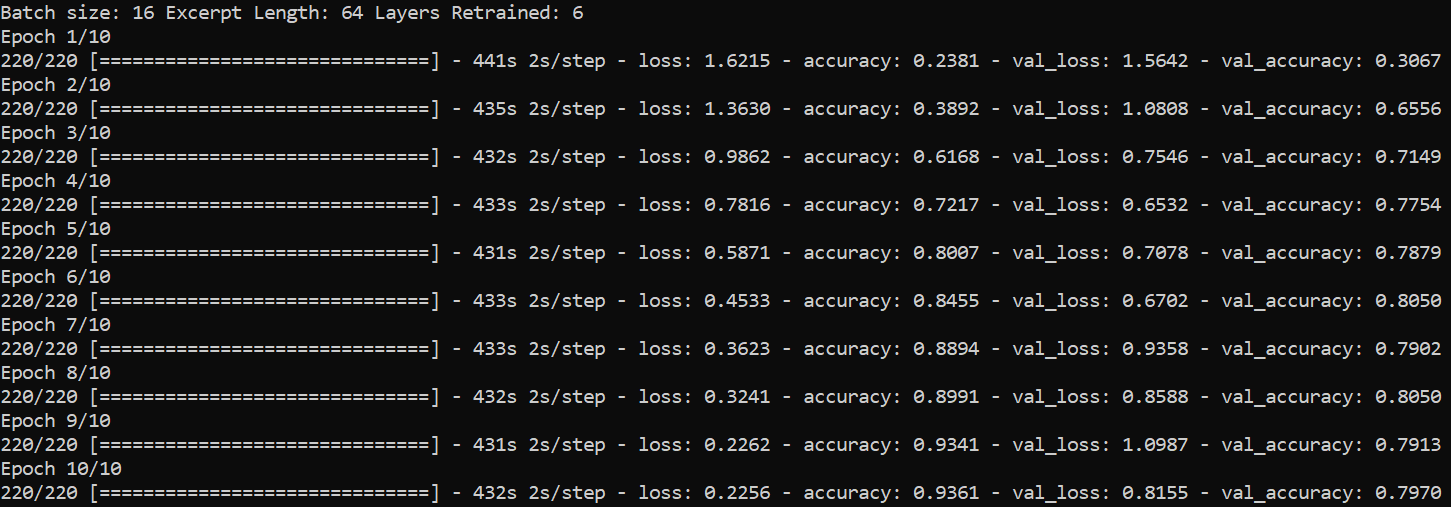

In [19]:
display(Image(filename='./screenshots/16_64_6.png'))

When retraining all 12 layers instead of only half, we get diminishing returns for increased validation accuracy. Our best performing model barely crests 80% validation accuracy.

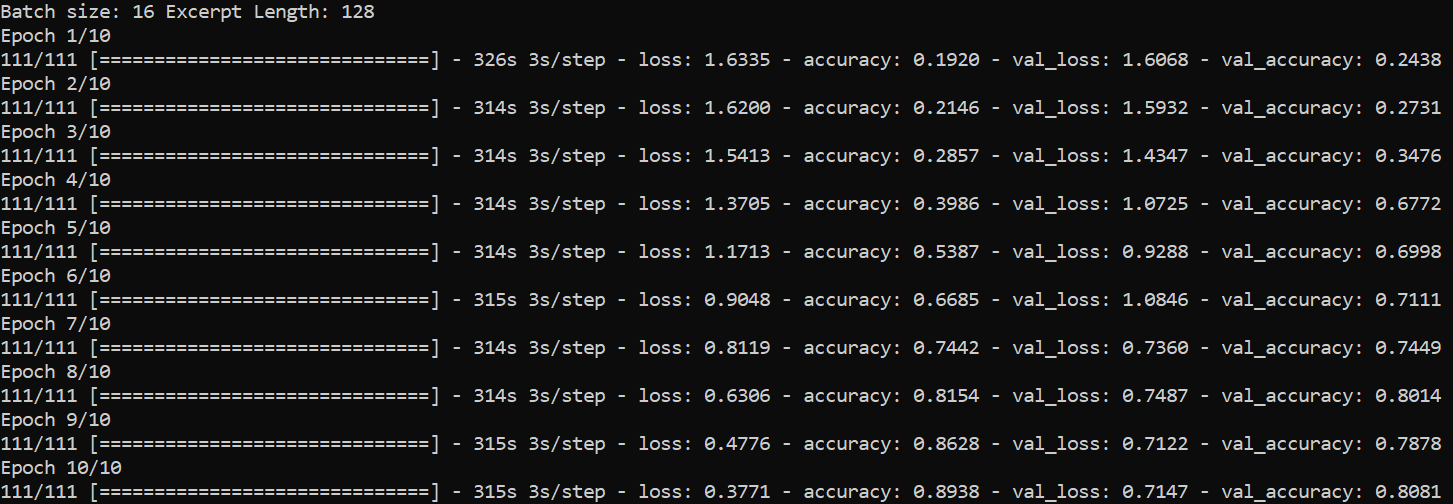

In [20]:
display(Image(filename='./screenshots/16_128_12.png'))

### Best Performing Model

Batch size of 16, Excerpt size of 128, Retrained 12 layers

In [35]:
bert_model_ft = tf.keras.models.load_model('./models/bert_classification_model_16_128_12.h5', custom_objects={"TFBertModel": bert_model})
x_train, x_test, y_train, y_test = format_data(n=128)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Note how the 80.81% validation accuracy matches that of Epoch 10 in the initial training.

In [23]:
bert_model_ft.evaluate([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask],
                       y_test)

14/14 [==============================] - 24s 2s/step - loss: 0.7147 - accuracy: 0.8081


[0.7146892547607422, 0.8081263899803162]

14/14 [==============================] - 23s 2s/step


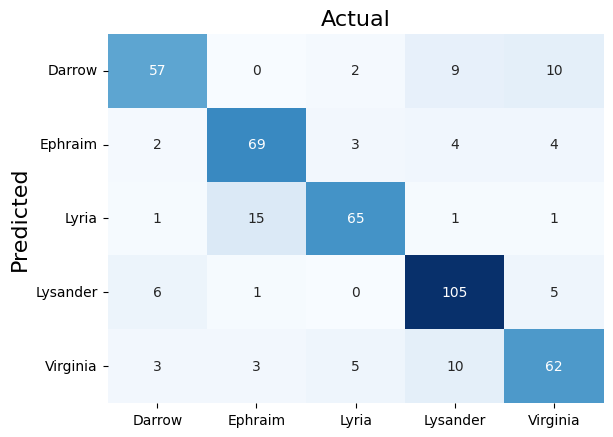

In [24]:
bert_cm = tf.math.confusion_matrix(
    np.argmax(y_test, axis=1),
    np.argmax(bert_model_ft.predict([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask]), axis=1),
)
classes = ['Darrow', 'Ephraim', 'Lyria', 'Lysander', 'Virginia']
sns.heatmap(bert_cm, annot=True, cbar=False, cmap="Blues", fmt="g", xticklabels=classes, yticklabels=classes)
plt.title('Actual', fontsize=16)
plt.ylabel('Predicted', fontsize=16)
plt.yticks(rotation=0)
plt.show()

The model performs very well at identifying the 'Lyria' perspective and performed modestly well on most of the others. Out of all the narrators, Lyria is the sole 'lowColor' (as Darrow is a de-facto Gold) and is the the sole non-combatant narrator. Note that the most substantial misclassification involved 15 'Ephraim' excerpts identified as 'Lyria'. Ephraim, alongside Lyria, is the only other non-Gold narrator in the novel who doesn't lead armies or govern.

For each of 'Darrow', 'Lysander' and 'Virginia' (the Gold or de-facto Gold rulers) there is more overlap with each other's excerpts than with the others.

In [46]:
from sklearn.metrics import classification_report

print(
    classification_report(
        np.argmax(y_test, axis=1),
        np.argmax(bert_model_ft.predict([x_test.input_ids, x_test.token_type_ids, x_test.attention_mask]), axis=1),
    )
)

14/14 [==============================] - 23s 2s/step
              precision    recall  f1-score   support

           0       0.83      0.73      0.78        78
           1       0.78      0.84      0.81        82
           2       0.87      0.78      0.82        83
           3       0.81      0.90      0.85       117
           4       0.76      0.75      0.75        83

    accuracy                           0.81       443
   macro avg       0.81      0.80      0.80       443
weighted avg       0.81      0.81      0.81       443



## Analysis of Out-of-Context Words

Here is the cosine_similarities method from class to calculate and print out the distances between given word embeddings.

In [47]:
def cosine_similarities(vecs):
    for v_1 in vecs:
        similarities = ''
        for v_2 in vecs:
            similarities += ('\t' + str(np.dot(v_1, v_2)/np.sqrt(np.dot(v_1, v_1) * np.dot(v_2, v_2)))[:4])
        print(similarities)

To determine if and how BERT fine-tuning learned contextual word meanings for out-of-context words, my approach will be to take the last hidden-state vector for the [CLS] token for key words from both the original pre-trained BERT and my fine-tuned BERT layers and calculate their cosine_similarities.

In [130]:
enc_1 = bert_tokenizer("Gold", return_tensors='tf')
enc_2 = bert_tokenizer("Gold", return_tensors='tf')

#Vector representation for "Gold" in pre-trained model
pt_1 = bert_model(enc_1)[0][-1][0]
#Vector representation for "Gold" in fine-tuned model
ft_1 = bert_model_ft.layers[3](enc_2)[0][-1][0]

cosine_similarities([pt_1, ft_1])

	1.0	0.52
	0.52	1.0


In [131]:
enc_1 = bert_tokenizer("Red", return_tensors='tf')
enc_2 = bert_tokenizer("Red", return_tensors='tf')

#Vector representation for "Gold" in pre-trained model
pt_1 = bert_model(enc_1)[0][-1][0]
#Vector representation for "Gold" in fine-tuned model
ft_1 = bert_model_ft.layers[3](enc_2)[0][-1][0]

cosine_similarities([pt_1, ft_1])

	1.0	0.41
	0.41	1.0


Here we see the cosine similarity between both 'Gold' and 'Red' respectively are vastly different in the fine-tuned model than the original pre-trained model. So what did we learn?

Here we will compare the pre-trained meaning (embedding) for 'ruler' to the learned fine-tuned embeddings for 'Red' and 'Gold'.

In [137]:
enc_1 = bert_tokenizer("ruler", return_tensors='tf')
enc_2 = bert_tokenizer("Red", return_tensors='tf')
enc_3 = bert_tokenizer("Gold", return_tensors='tf')

#Vector representation for "ruler" in pre-trained model
pt_1 = bert_model(enc_1)[0][-1][0]
#Vector representation for "Red" in fine-trained model
pt_2 = bert_model_ft.layers[3](enc_2)[0][-1][0]
#Vector representation for "Gold" in fine-tuned model
ft_1 = bert_model_ft.layers[3](enc_3)[0][-1][0]

cosine_similarities([pt_1, pt_2, ft_1])

	1.0	0.40	0.53
	0.40	1.0	0.82
	0.53	0.82	1.0


We see the learned embeddings for 'Red' and 'Gold' are relatively similar (0.82). We also see that 'ruler' and 'Red' are very different from each other (0.40) but a bit closer between 'ruler' and 'Gold' (0.53). At a glance, it looks like the model learned something about the novel's Color caste system!

In the novel, Virginia is the Sovereign (ruler) of the Republic. Did the model learn about that?

The pre-trained embedding for 'Sovereign' is quite different to the post-tuning embedding for 'Virginia'.

In [138]:
enc_1 = bert_tokenizer("Sovereign", return_tensors='tf')
enc_2 = bert_tokenizer("Virginia", return_tensors='tf')

#Vector representation for "Sovereign" in pre-trained model
pt_1 = bert_model(enc_1)[0][-1][0]
#Vector representation for "Virginia" in fine-tuned model
ft_1 = bert_model_ft.layers[3](enc_2)[0][-1][0]

cosine_similarities([pt_1, ft_1])

	1.0	0.54
	0.54	1.0


However, the post-tuning embedding for 'Sovereign' is much more similar to the post-tuning embedding for 'Virginia'. It looks like the model learned something!

In [139]:
enc_1 = bert_tokenizer("Sovereign", return_tensors='tf')
enc_2 = bert_tokenizer("Virginia", return_tensors='tf')

#Vector representation for "slave" in pre-trained model
pt_1 = bert_model_ft.layers[3](enc_1)[0][-1][0]
#Vector representation for "Red" in fine-tuned model
ft_1 = bert_model_ft.layers[3](enc_2)[0][-1][0]

cosine_similarities([pt_1, ft_1])

	1.0	0.76
	0.76	1.0
